# Humidity data

## Import libraries

In [3]:
"""Basic ones"""
import polars as pl
from plotnine import *
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.show()  # for display figures after ggplot
# plt.rcParams['axes.grid'] = True
import numpy as np
import seaborn as sns
import pandas
import statsmodels.api as sm
from datetime import datetime

import warnings
warnings.simplefilter("ignore")

/home/kota/anaconda3/envs/bayes/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4


## Load data

- 日平均蒸気圧
- 日平均相対湿度
- 日最小相対湿度
- ~~最小値の発生時刻~~

In [4]:
file_name = "../../data/weather/humidity.csv"
df = pl.read_csv(file_name, encoding="shift-jis", skip_rows=3)
display(df.columns)
df.columns = ["date", "day_of_week", "mean_vapor", "mean_humidity", "min_humidity", "min_humidity_time"]
df = df.with_columns(pl.col("date").str.strptime(pl.Date, "%Y/%m/%d")) # convert day column data type into date type
df = df.with_columns(pl.col("min_humidity_time").str.strptime(pl.Datetime, "%Y/%m/%d %H:%M")) # convert time column data type into datetime
df.head()

['年月日', '曜日', '平均蒸気圧(hPa)', '平均湿度(％)', '最小相対湿度(％)', '最小相対湿度(％)時分']

date,day_of_week,mean_vapor,mean_humidity,min_humidity,min_humidity_time
date,str,f64,i64,i64,datetime[μs]
2017-07-01,"""土""",23.8,88,63,2017-07-01 15:01:00
2017-07-02,"""日""",25.9,91,63,2017-07-02 11:21:00
2017-07-03,"""月""",26.3,89,56,2017-07-03 17:54:00
2017-07-04,"""火""",25.6,97,87,2017-07-04 15:42:00
2017-07-05,"""水""",23.7,82,62,2017-07-05 16:07:00


## Check nulls

In [5]:
display(df.null_count())

nulls = df.hstack(df.transpose().select(pl.all().is_null().sum()).transpose().rename({"column_0": "null_count"}))
nulls.filter(pl.col("null_count") != 0)

date,day_of_week,mean_vapor,mean_humidity,min_humidity,min_humidity_time
u32,u32,u32,u32,u32,u32
0,0,3,3,3,3


date,day_of_week,mean_vapor,mean_humidity,min_humidity,min_humidity_time,null_count
date,str,f64,i64,i64,datetime[μs],u32
2017-10-22,"""日""",null,null,null,null,4
2017-10-23,"""月""",null,null,null,null,4
2017-10-24,"""火""",null,null,null,null,4


What should I do then... I didn't suppose weather data has several nulls.

## Visualization

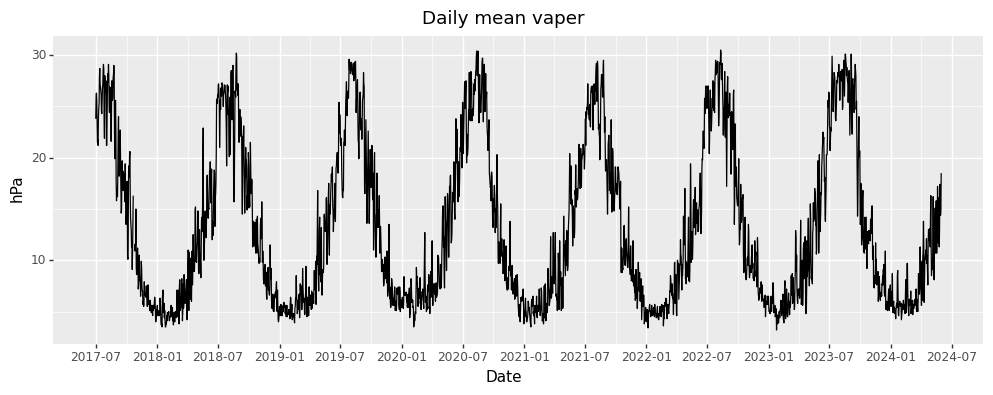

<ggplot: (8737332848734)>

In [6]:
(
    ggplot(data=df, mapping=aes(x="date"))
    + geom_line(aes(y="mean_vapor"))
    + labs(title="Daily mean vaper", x="Date", y="hPa")
    + theme(figure_size=(12, 4))
    + scale_x_date(
    #     limits=(
    #         datetime(year=2018, month=1, day=1),
    #         datetime(year=2022, month=1, day=1)
    #     ),
        date_labels="%Y-%m",
        date_breaks="6 month",
    #     # expand=(0, 1),
    #     date_minor_breaks="1 month",
    )
)

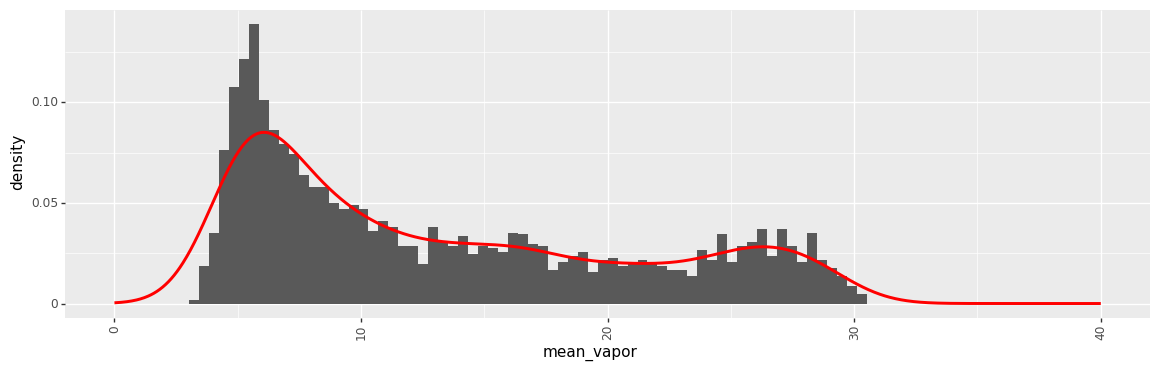

<ggplot: (8737331602093)>

In [7]:
(
    ggplot(data=df, mapping=aes(x="mean_vapor"))
    + geom_histogram(aes(y="..density.."), bins=100)
    + geom_density(size=1.2, color="red")
    + scale_x_continuous(breaks=range(0, 40, 1))
    + theme(figure_size=(14, 4), axis_text_x=element_text(rotation=90))
    + xlim(0, 40)
)

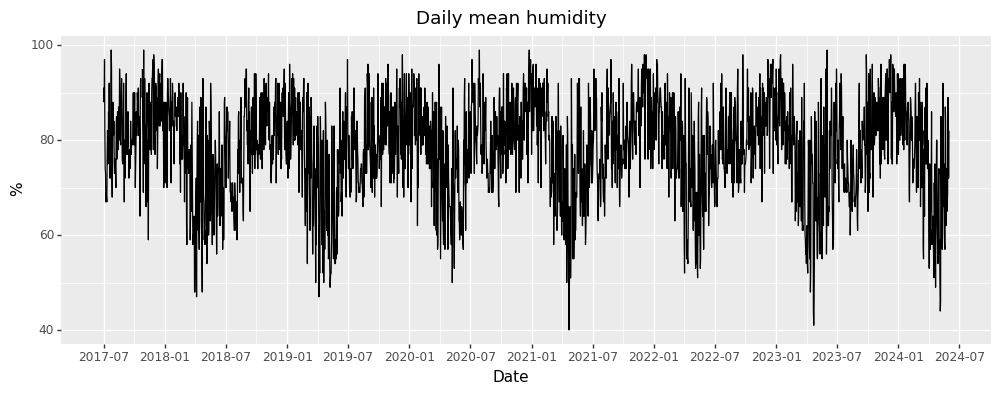

<ggplot: (8737331545182)>

In [8]:
(
    ggplot(data=df, mapping=aes(x="date"))
    + geom_line(aes(y="mean_humidity"))
    + labs(title="Daily mean humidity", x="Date", y="%")
    + theme(figure_size=(12, 4))
    + scale_x_date(
    #     limits=(
    #         datetime(year=2018, month=1, day=1),
    #         datetime(year=2022, month=1, day=1)
    #     ),
        date_labels="%Y-%m",
        date_breaks="6 month",
    #     # expand=(0, 1),
    #     date_minor_breaks="1 month",
    )
)

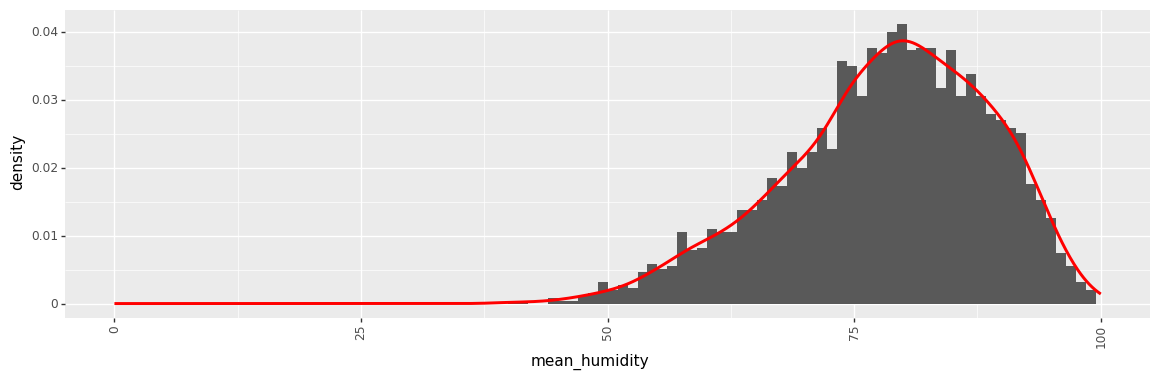

<ggplot: (8737287898899)>

In [38]:
(
    ggplot(data=df, mapping=aes(x="mean_humidity"))
    + geom_histogram(aes(y="..density.."), bins=100)
    + geom_density(size=1.2, color="red")
    + scale_x_continuous(breaks=range(40, 100+1, 1))
    + theme(figure_size=(14, 4), axis_text_x=element_text(rotation=90))
    + xlim(0, 100)
)

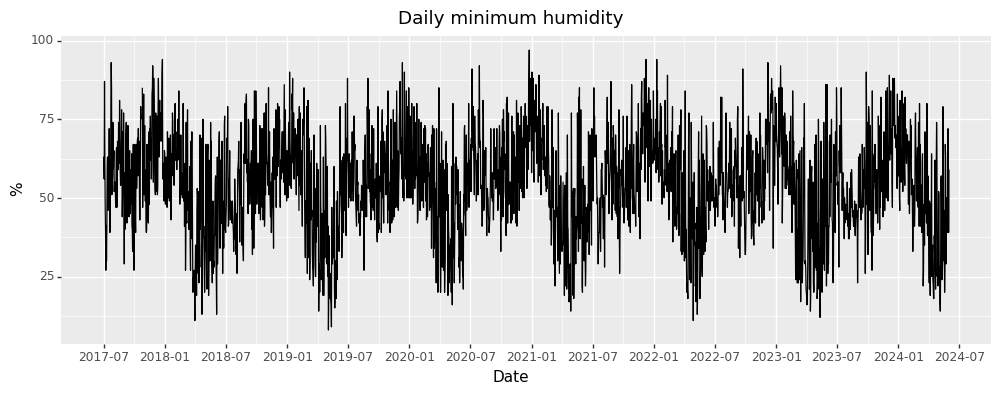

<ggplot: (8737332848998)>

In [10]:
(
    ggplot(data=df, mapping=aes(x="date"))
    + geom_line(aes(y="min_humidity"))
    + labs(title="Daily minimum humidity", x="Date", y="%")
    + theme(figure_size=(12, 4))
    + scale_x_date(
    #     limits=(
    #         datetime(year=2018, month=1, day=1),
    #         datetime(year=2022, month=1, day=1)
    #     ),
        date_labels="%Y-%m",
        date_breaks="6 month",
    #     # expand=(0, 1),
    #     date_minor_breaks="1 month",
    )
)

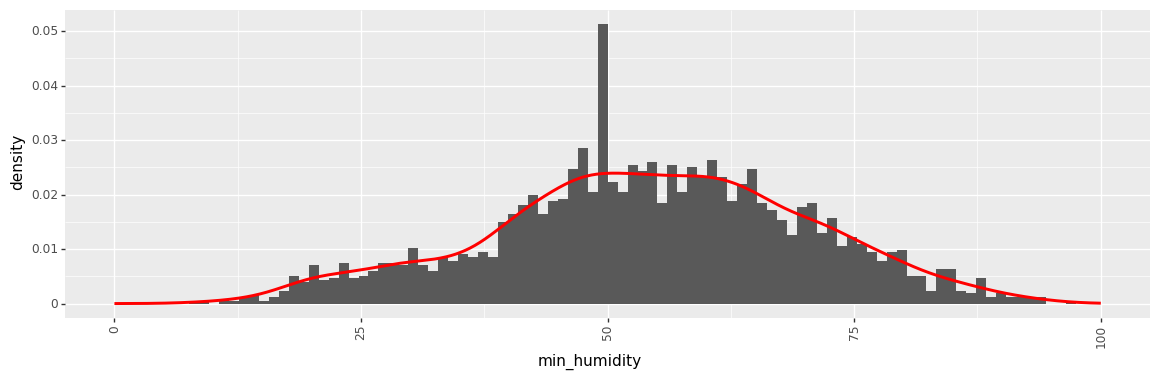

<ggplot: (8737314785452)>

In [11]:
(
    ggplot(data=df, mapping=aes(x="min_humidity"))
    + geom_histogram(aes(y="..density.."), bins=100)
    + geom_density(size=1.2, color="red")
    + scale_x_continuous(breaks=range(40, 100+1, 1))
    + theme(figure_size=(14, 4), axis_text_x=element_text(rotation=90))
    + xlim(0, 100)
)

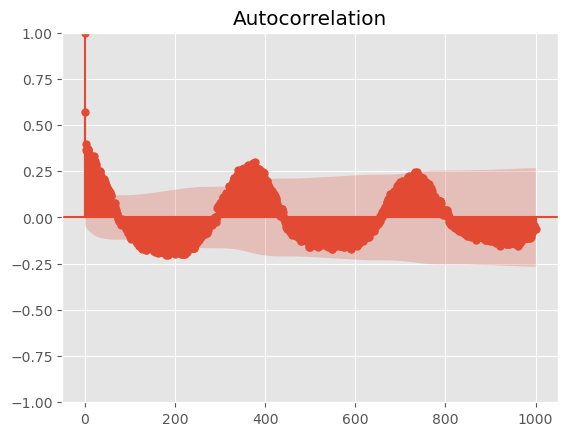

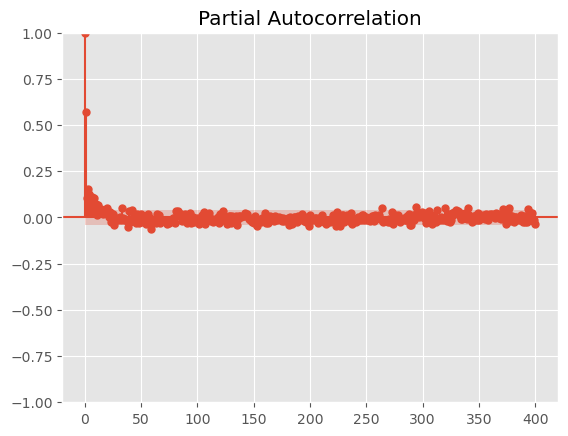

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df["mean_humidity"].drop_nulls(), lags=1000);
plot_pacf(df["mean_humidity"].drop_nulls(), lags=400);

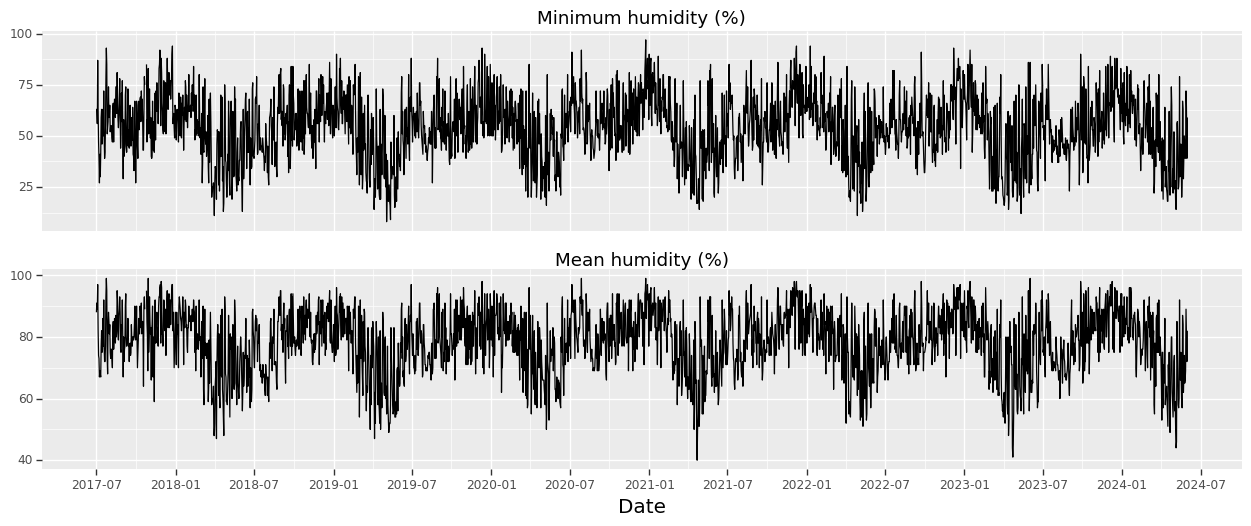

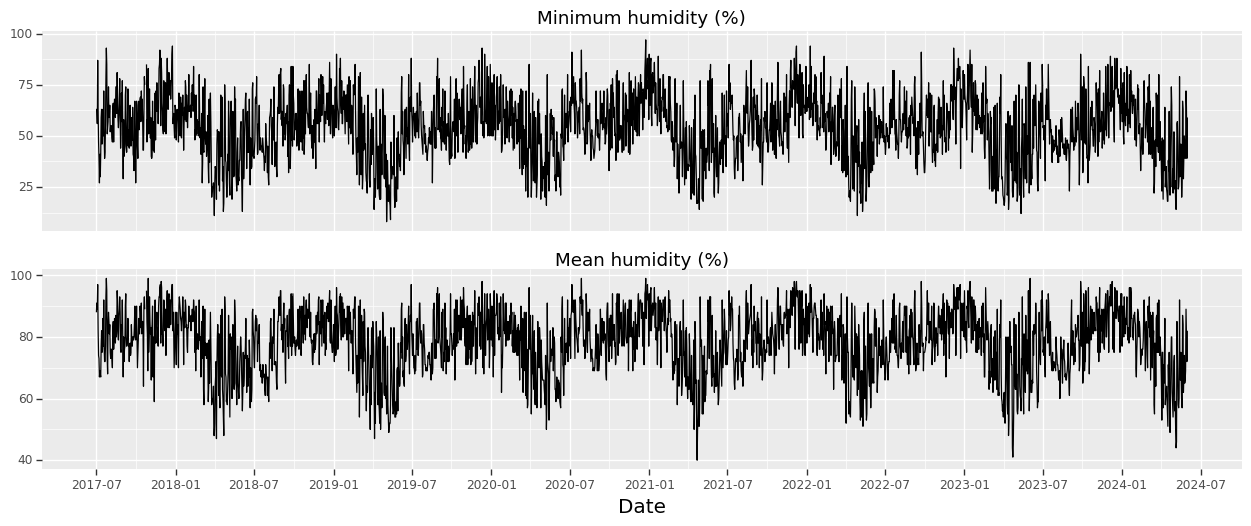

In [13]:
# https://github.com/has2k1/plotnine/issues/46

import patchworklib as pw
from plotnine import *
from plotnine.data import *

g1 = pw.load_ggplot(
    ggplot(data=df, mapping=aes(x="date"))
    + geom_line(aes(y="min_humidity"))
    + labs(title="Minimum humidity (%)", x="Date", y="")
    + theme(figure_size=(12, 2), axis_title_x=element_blank(), axis_ticks_major_x=element_blank()
            , axis_ticks_minor_x=element_blank(), axis_text_x=element_blank())
    + scale_x_date(
        date_labels="%Y-%m",
        date_breaks="6 month",
    )
)

g2 = pw.load_ggplot(
    ggplot(data=df, mapping=aes(x="date"))
    + geom_line(aes(y="mean_humidity"))
    + labs(title="Mean humidity (%)", x="Date", y="")
    + theme(figure_size=(12, 2))
    + scale_x_date(
        date_labels="%Y-%m",
        date_breaks="6 month",
    )
)


pw.param["margin"] = 0.2
(
    g1 / g2
).savefig(fname="../../fig/weather/hum.png", dpi=500)  # By specifying g3 in (g3|g2), g1 is positioned exactly on g3.

In [14]:
# import pandas as pd
# from plotnine import ggplot, aes, geom_line, facet_wrap, theme, element_blank

# # サンプルデータの作成
# df = pd.DataFrame({
#     'time': list(range(10)),
#     'A': [1, 3, 2, 5, 7, 6, 8, 10, 9, 12],
#     'B': [2, 4, 3, 6, 8, 7, 9, 11, 10, 13],
#     'C': [3, 5, 4, 7, 9, 8, 10, 12, 11, 14]
# })

# # 長形式に変換
# df_melted = df.melt(id_vars=['time'], var_name='variable', value_name='value')

# # プロットの作成
# p = (ggplot(df_melted, aes('time', 'value', color='variable'))
#      + geom_line()
#      + facet_wrap('~variable', ncol=1)
#      + theme(subplots_adjust={'hspace': 0.25})
#      + theme(axis_title_x=element_blank(),
#              axis_text_x=element_blank(),
#              axis_ticks_major_x=element_blank(),
#              axis_ticks_minor_x=element_blank()))

# print(p)


### Features visually

- Yearly trend in all of them
- fjd
- bayma
- horse